# Fluvial Working Group Document

<img src="https://i.imgur.com/jS8EqiI.jpg" alt="conceptual framework" width="500"/>

In [148]:
# First, import packages

import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from landlab.components import OverlandFlow, FlowAccumulator, SpatialPrecipitationDistribution, FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.components import SoilInfiltrationGreenAmpt
from landlab import RasterModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile
from landlab import ExampleData
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node
from landlab.io.esri_ascii import read_esri_ascii, write_esri_ascii

from landlab.plot import plot_network_and_parcels
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.colors as mcolors
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

#Hillshading
from matplotlib.colors import LightSource

# #Animation
#import imageio
#from glob import glob


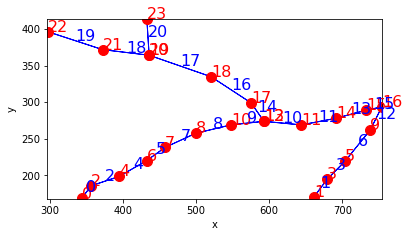

In [149]:
# set up overland flow for driving runoff

shp_file = 'hugo_links.shp'
# points_shapefile = '../hugo_nodes_nodublicates.shp'

grid = read_shapefile(
    shp_file,
    threshold=0.1,
    )

graph.plot_graph(grid, at="node,link")

In [150]:
#Drop double nodes
drop_nodes = [19,13]
new_y_of_node =[]
new_x_of_node =[]
#Find the new x and y coordinates
for i, node in enumerate(grid.y_of_node):
    if i not in drop_nodes:
        new_y_of_node.append(node)

for i, node in enumerate(grid.x_of_node):
    if i not in drop_nodes:
        new_x_of_node.append(node)


In [151]:
#rediect all nodes
replace_nodes = [20,12]
nodes_reformatted=np.ravel(grid.nodes_at_link)

for node, replacement in zip(drop_nodes,replace_nodes):
    nodes_reformatted[np.where(nodes_reformatted==node)]=replacement

In [152]:
#change index number     
for node in drop_nodes:
    nodes_reformatted[np.where(nodes_reformatted >node)] -=1
    
new_nodes_at_link=nodes_reformatted.reshape([21,2])

In [153]:
# set up network driving sediment transport and morphodynamics

# Make a new network model grid
new_grid = NetworkModelGrid((new_y_of_node, new_x_of_node), new_nodes_at_link)

# graph.plot_graph(new_grid, at="node,link")

#Define grid
# here we use an arbitrary, very small, "real" catchment
fname = 'hugo_site.asc'
rmg, z = read_esri_ascii(fname, name='topographic__elevation')
# rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED
rmg.set_watershed_boundary_condition('topographic__elevation')

# Initial conditions
run_time =50000# 1 day 259200  # duration of run, (s) equivalent of 3 days
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.
h_init = 0.1 # initial thin layer of water (m)

#Set up rain
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
h = rmg.at_node['surface_water__depth']
h+=h_init #add a little bit of water everywhere

#ad a storm 
bools = (rmg.node_y > 100) * (rmg.node_y < 450) * (rmg.node_x < 400) * (rmg.node_x > 200)
h[bools] = 0.1 #initial water depth m

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)


In [154]:
nmg_node_topo = np.zeros(new_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_h = np.zeros(new_grid.number_of_nodes)

for i in range(new_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[i], new_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]

nmg_link_length = np.zeros(new_grid.number_of_links)
nmg_link_h = np.zeros(new_grid.number_of_links)

In [155]:
for i in range(new_grid.number_of_links):
    idx_node_1_link = new_grid.nodes_at_link[i][0]
    idx_node_2_link = new_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((new_grid.x_of_node[idx_node_2_link] - new_grid.x_of_node[idx_node_1_link])**2 
                         + (new_grid.y_of_node[idx_node_2_link] - new_grid.y_of_node[idx_node_1_link])**2)
    square_idx = rmg.find_nearest_node([new_grid.x_of_node[idx_node_1_link], new_grid.y_of_node[idx_node_1_link]]) #get raster grid idx closest to link tail
    nmg_link_h[i] = rmg.at_node['surface_water__depth'][square_idx] #assign surface at square_idx to network grid

new_grid.at_node["topographic__elevation"] = nmg_node_topo.copy()

new_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

new_grid.at_link["channel_width"] = 10 * np.ones(grid.number_of_links)

new_grid.at_link["flow_depth"] = nmg_link_h.copy()

new_grid.at_link["reach_length"] = nmg_link_length

In [156]:
# Folder for rainfall data
dir_rainfall = './rainfall_series'
# Overwrite or create directory for rainfall data
if os.path.exists(dir_rainfall):
    shutil.rmtree(dir_rainfall)
os.makedirs(dir_rainfall)

# time scale for rainfall events. To be adjusted. I am cheating with units... 
nb_years = 100
# Factor to scale rainfall values from the module SpatialPrecipitationDistribution (may generate very
# small amounts of rainfall, which renders poorly...)
rainfall_scaling = 10.

# Create time series of rainfall events (output is in mm/h)
rain = SpatialPrecipitationDistribution(rmg,number_of_years = nb_years)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every tim

# Container for rainfall duration
storm_t_all = []
interstorm_t_all = []

# get the storm simulator to provide a storm
# Variables required to generate rainfall datasets
i = 0
max_rainfall = []
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    i += 1
    rmg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    rmg.at_node['rainfall__flux'] *= rainfall_scaling  # to make the storm heavier and more interesting!

    # Save rainfall data to ascii file
    write_esri_ascii('./'+ dir_rainfall +'/rainfall_'+ str(i) + '.asc', rmg, 'rainfall__flux', clobber=True)
    
    # Save duration of storm and non-storm periods
    storm_t_all.append(storm_t)
    interstorm_t_all.append(interstorm_t)
    
    # Store max rainfall value
    max_rainfall.append(max(rmg.at_node['rainfall__flux']))

storm_ids = np.array(range(len(storm_t_all))) + 1

# Get moment of storms (initially in hours, to be rescaled over run_time 
# -> cheating to get some results...)
days_storms = (np.array(interstorm_t_all)/24)
scaled_days_storms_steps = (days_storms * (run_time / (nb_years*365))).round()
scaled_days_storms = scaled_days_storms_steps.cumsum()
# Set first storm a time = 1
scaled_days_storms = scaled_days_storms - scaled_days_storms[0] + 1

#Set initial water depth values and rainfall flux values
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
rmg.at_node.pop('rainfall__flux')
# print(rmg.at_node.keys())

# Read first rainfall data
q_rain = read_esri_ascii(dir_rainfall + '/rainfall_1.asc', grid=rmg, name='rainfall__flux')
# Update id for rainfall
rainfall_id = 1

# Update surface water depth with rainfall data
rmg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
rmg.at_node['surface_water__depth'] += rmg.at_node['rainfall__flux'] # storm_t_all[0]

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)



In [157]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(new_grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.002 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [158]:
lithology = ["quartzite"] * np.size(element_id)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}


items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    new_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

dt_sed = 100 # 60 * 60 * 24 *1# length of timestep (seconds) 

In [159]:
# # this section can take selveral minutes to run
# #MUST RUN ALL CELLS ABOVE BEFORE THIS CELL
# elapsed_time = 1.
# run_time_slices = np.arange(dt_sed,run_time+1,dt_sed) #every sed transport timestep
  
# #Run model
# for t in run_time_slices:
#     #Run overland until next time to run sed transport
#     while elapsed_time < t: 
#         # First, we calculate our time step.
#         dt_overland = of.calc_time_step()
#         #print('overland flow timestep is',dt_overland,'seconds')
#         # Now, we can generate overland flow.
#         of.overland_flow()
#         # Increased elapsed time
#         elapsed_time += dt_overland
#         #print("Model time: ",elapsed_time/(60*60*24), "days passed")
#         ## Append time and discharge and water depth to their lists to save data and for plotting.
#         hydrograph_time.append(elapsed_time) 
#         q = rmg.at_link["surface_water__discharge"]
#         discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
#         h = rmg.at_node['surface_water__depth']
#         height_at_outlet.append(np.abs(h[outlet_nearest_raster_cell]))


    
#         # updated the water depth in network graph
#         for i in range(new_grid.number_of_links):
#             idx_node_2_link = new_grid.nodes_at_link[i][1]
#             nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_node_2_link] #assume second node is downstream one
#         new_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
#     #Make more rain 
# #     rmg.at_node['surface_water__depth'][bools] += 2*dt_sed/(60*60)
#     #water depth d
#     #Run sed transport 
#         nst.run_one_step(dt_overland)
#     #print("Sed transporter run at model time: ",elapsed_time/(60*60*24), "days passed")

    
# #     Plot overland flow 
#     fig=plt.figure()
#     imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
#     imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
#     plt.title(f'Time = {round(elapsed_time,1)} s')
#     plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
#     plt.show()
#     fig.savefig(f"Hima_results/runoff_{round(elapsed_time,1)}.jpeg")
    
    
#     #grain size
#    parcel_D = parcels.dataset.D.values.copy()
#    parcel_D_off_grid=parcel_D[parcels.dataset["element_id"].values==-2] 

#     # the histogram of the data
#     plt.hist(parcel_D_off_grid*1000, histtype='bar')

#     plt.xlabel('grain size (mm)')
#     plt.ylabel('Count')
#     plt.title('Histogram of grain sizes that left grid')
#     plt.text(0.011, 700, r'original distribution $\mu=2 mm$')
#     plt.xlim(0, 20)
#     plt.ylim(0, 4000)
#     plt.grid(True)
#     plt.show()

# #     Plot sediment parcels locations
#     fig = plot_network_and_parcels(
#             grid, parcels, 
#             parcel_time_index=len(parcels.time_coordinates)-1)
#     plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
#     plt.title(f'Time = {round(elapsed_time,1)} s')
#     plt.show()
#     fig.savefig(f"Hima_results/sedparcels_{round(elapsed_time,1)}.jpeg")

In [160]:
# set up overland flow grid for small-scale floodplain

nX = 200
nY = 100
spacing = 1.0
Datum = 500
h_initFP = 0.1

Channel_Width = 8.
Channel_Depth = 2.

def makeFP(Channel_Depth, Channel_Width = 8):
    
    #Define grid
    nX = 200
    nY = 100
    spacing = 1.0
    Datum = 500
    h_initFP = 0.1

    _grd = RasterModelGrid((nX, nY), xy_spacing=1.)

    # Pointer to topographic elevation > z
    _z = np.ones(nX*nY) * Datum
    _z = _grd.add_field('topographic__elevation', _z, at='node')

    # Add a longitudinal slope 
    ## (makes thing flow north to south)
    Long_Slope = 1./1000
    _z += _grd.node_y*Long_Slope

    # Add the channel indentation 
    ## (it's just a straigth strip)
    
    isChannel = (_grd.node_x > (nY/2 - Channel_Width/2)) * (_grd.node_x < (nY/2 + Channel_Width/2))
    _z[isChannel] -= Channel_Depth

    # Add a slope to the banks
    ## (so water flows always towards the main channel)
    Transversal_Slope = 1./100
    _z += np.abs(_grd.node_x-(nY/2))*Transversal_Slope

    # Add some random noise to the floodplains
    ## (makes the hillshading look prettier)
    _z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[int(nX/10),int(nY/10)]),nX*nY) 
    
    return _grd, _z, isChannel


In [161]:
gridFP, zFP, isChannel = makeFP(Channel_Depth = 2)

# # Plot 2D domain topography
# fig = plt.figure(figsize=(10,8))
# ls = LightSource(azdeg=315, altdeg=45)
# plt.imshow(ls.hillshade(np.reshape(zFP,[nX,nY]), vert_exag=10), cmap='gray')
# plt.show()

In [162]:
# Pointer to surface water depth in the 2D floodplain
hFP = np.zeros(nX*nY)
bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)
hFP[bools] = Channel_Depth*0.5
hFP += h_initFP
hFP = gridFP.add_field('surface_water__depth', hFP, at='node')

#####################################
# Spatially variable hydraulic cond. 
#####################################

dFP = gridFP.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
dFP *= 0.2

hcFP = gridFP.add_ones('hydraulic_conductivity', at='node')
hcFP *= 1.0E-5

infBandWidthNorm = 0.3
infBandWidth = nY/2 * infBandWidthNorm

channel_left = (nY + Channel_Width) / 2
channel_right = (nY - Channel_Width) / 2

#Define high infiltration bands at the banks

highInfBand = np.logical_and(gridFP.x_of_node < channel_left + infBandWidth, 
                             gridFP.x_of_node > channel_right - infBandWidth)
inf_maskFP = np.logical_xor(highInfBand, isChannel)

hcFP[inf_maskFP] *= 10

# # Plot 2D domain hydraulic cond.
# fig = plt.figure(figsize=(10,8))
# plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
# imshow_grid(grid,'hydraulic_conductivity',cmap=WaterMap)
# plt.title("Hydraulic Conductivity")
# fig.show()

In [163]:
# Initialize model components

# overland flow in the floodplain
floodplainOF = OverlandFlow(gridFP, steep_slopes=True)

# soil infiltration in the floodplain
SI = SoilInfiltrationGreenAmpt(gridFP, hydraulic_conductivity=hcFP)

# Flow direction in channel network
fd = FlowDirectorSteepest(new_grid, "topographic__elevation")
fd.run_one_step()

#network sed transporter 
nst = NetworkSedimentTransporter(    
    new_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

# overland flow in the channel network
networkOF = OverlandFlow(rmg, steep_slopes=True)
networkOF.run_one_step()

In [164]:
# look at hydrograph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Define the outlet 
outlet_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[14], new_grid.y_of_node[14]]) 
# did not choose 15 since at boundary
outlet_link_to_sample = rmg.links_at_node[outlet_nearest_raster_cell][3]

3.55867487545
5.4670863485
[  4.14383650e-02   2.13335410e-02   1.73213040e-02   3.52225049e-02
   4.14848255e-02   4.15595866e-02   2.80930709e-02   8.34717392e-04
   1.28841958e-02   9.89356482e-05   1.69645928e-02   1.90561695e-03
   2.97642918e-02   1.85535609e-02   1.69645928e-02   9.21152452e-04
   1.65450695e-02   2.14189377e-02   4.55215292e-02   4.61009022e-03
   2.14189377e-02]


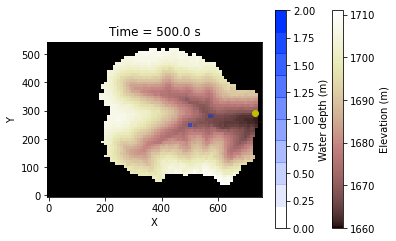

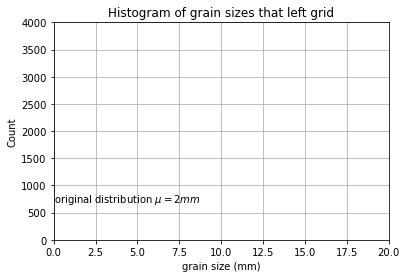

0.1
1665.0
1665.0
59.5454531102
[ 0.22515356  0.06342519  0.23848025  0.11629582  0.44634815  0.37904435
  0.11409177  0.00430348  0.13285419  0.00074064  0.36353143  0.04393504
  0.55833112  0.18256884  0.36353143  0.00377911  0.706314    0.2488727
  0.31245224  0.0156961   0.2488727 ]


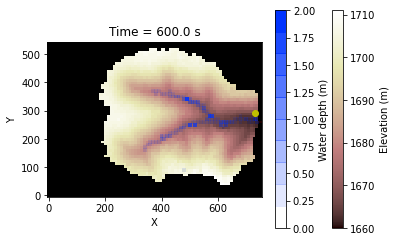

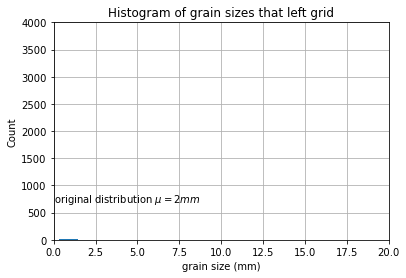

0.1
1665.0
1665.0
[  1.05588414e-01   3.28309046e-02   5.25247495e-02   5.62226519e-02
   1.43436281e-01   1.74064110e-01   4.76746277e-02   3.93470625e-03
   9.00451519e-02   4.05470836e-04   3.40141082e-01   6.11321936e-02
   9.08642744e-01   2.70286767e-01   3.40141082e-01   1.84642606e-03
   3.94007788e-01   8.70500671e-02   1.15741317e-01   1.02235246e-02
   8.70500671e-02]


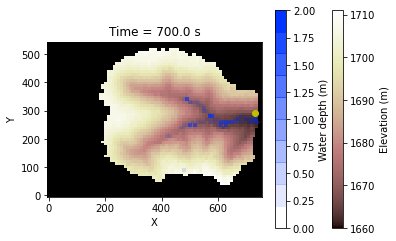

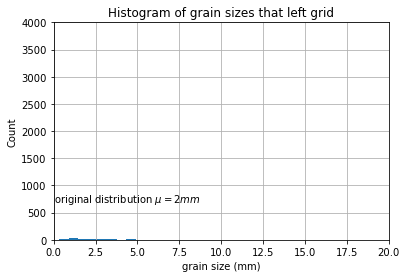

0.1
1665.0
1665.0
100.514539598
[ 0.34109677  0.17772896  0.18614005  0.21483694  0.2940851   0.25304516
  0.14714951  0.05464428  0.15528271  0.02016503  0.27876383  0.06216569
  0.89993579  0.27057461  0.27876383  0.03687222  0.38558874  0.18888648
  0.36462685  0.13971857  0.18888648]


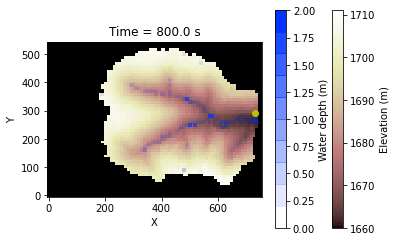

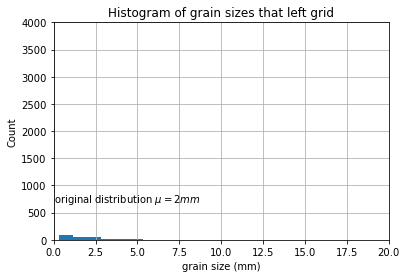

0.1
1665.0
1665.0
[ 0.28691036  0.06990428  0.3392867   0.12522986  0.77866418  0.62603591
  0.11335771  0.01030985  0.29235501  0.01019558  0.62157179  0.23360423
  1.35242246  0.35992215  0.62157179  0.00664827  1.20378248  0.44816105
  0.44953334  0.02003452  0.44816105]


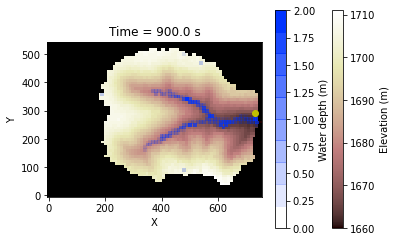

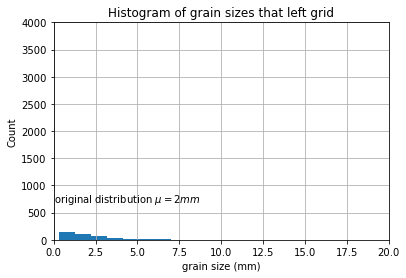

0.1
1665.0
1665.0
[  1.33403748e-01   3.90164652e-02   6.04808349e-02   6.46853972e-02
   1.79566493e-01   2.18373703e-01   5.44475264e-02   1.29132708e-03
   1.25453171e-01   3.39860760e-03   5.54584039e-01   2.87160079e-01
   1.76331281e+00   6.02776389e-01   5.54584039e-01   4.97918844e-03
   5.52067567e-01   1.07346534e-01   1.36604314e-01   1.36964833e-02
   1.07346534e-01]


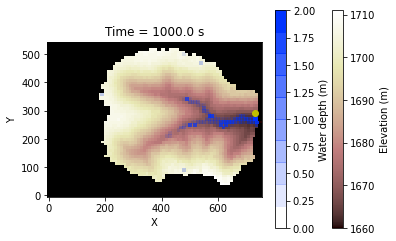

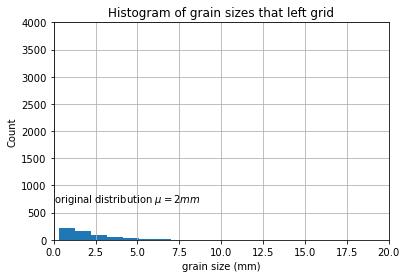

0.1
1665.0
1665.0
11.9266020002
[  1.23158111e-01   5.54956090e-02   5.90335024e-02   9.53366846e-02
   1.46239826e-01   1.60166306e-01   7.43127002e-02   4.82403286e-03
   5.41444171e-02   2.07739300e-04   2.58139518e-01   3.31384031e-02
   1.50000956e+00   2.67031316e-01   2.58139518e-01   3.43971937e-03
   3.25446502e-01   1.06687347e-01   1.49820451e-01   1.44578184e-02
   1.06687347e-01]


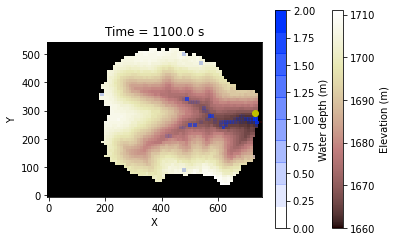

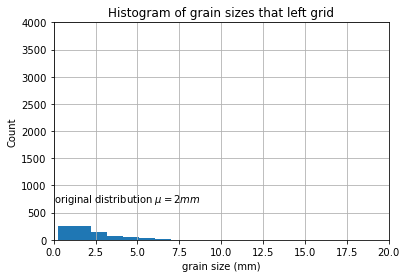

0.1
1665.0
1665.0
[  7.41520542e-02   2.92724079e-02   3.33536573e-02   5.32423641e-02
   9.34051915e-02   1.13284053e-01   4.59281648e-02   1.90679303e-03
   3.99989678e-02   3.84197903e-05   1.89708460e-01   1.50931188e-02
   5.24790144e-01   1.52172960e-01   1.89708460e-01   1.58753171e-03
   2.29994882e-01   6.89619381e-02   9.85287290e-02   8.88275683e-03
   6.89619381e-02]


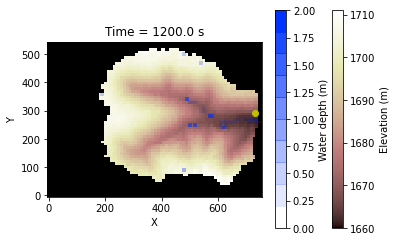

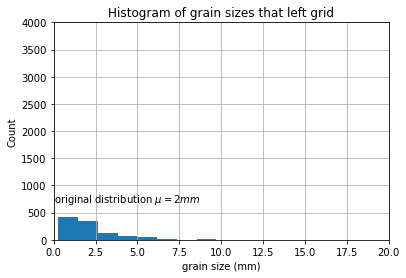

0.1
1665.0
1665.0
0.0250501673038
[  5.31844617e-02   2.07989834e-02   2.61129314e-02   3.57443288e-02
   6.39842784e-02   7.70980992e-02   2.86899910e-02   9.41879838e-04
   2.59919550e-02   1.00000000e-08   1.36187809e-01   7.08772310e-03
   2.80791082e-01   1.01027105e-01   1.36187809e-01   9.20741334e-04
   1.50234191e-01   4.49462740e-02   6.68836453e-02   6.47352999e-03
   4.49462740e-02]


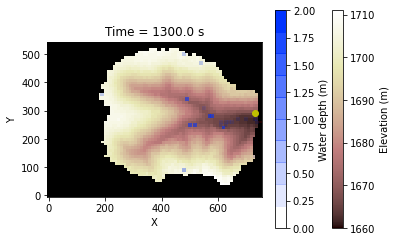

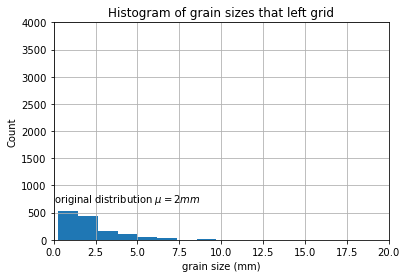

0.1
1665.0
1665.0
[  4.05841213e-02   1.52915339e-02   1.85682435e-02   2.62770363e-02
   5.20828375e-02   5.97662782e-02   2.20940748e-02   5.37384818e-04
   2.01915890e-02   1.00000000e-08   9.51370089e-02   3.95236832e-03
   1.49652258e-01   6.78237430e-02   9.51370089e-02   5.57944230e-04
   1.07605447e-01   3.58888405e-02   5.27639676e-02   4.23592203e-03
   3.58888405e-02]


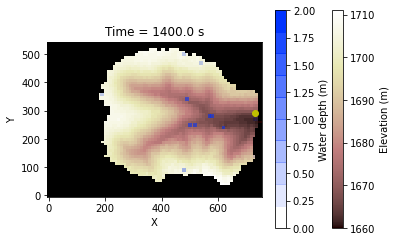

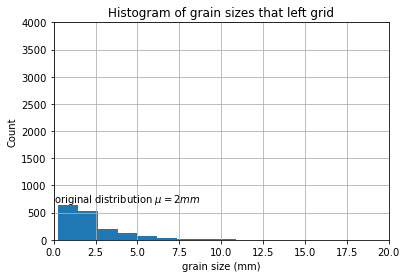

0.1
1665.0
1665.0
[  3.22936366e-02   1.16169990e-02   1.37788221e-02   2.06942071e-02
   4.18469609e-02   4.90753091e-02   1.77420027e-02   3.57449687e-04
   1.51000762e-02   1.00000000e-08   7.59434142e-02   2.50024072e-03
   8.67677929e-02   4.86794998e-02   7.59434142e-02   3.76854761e-04
   8.58316328e-02   2.90716079e-02   4.22101682e-02   2.99890723e-03
   2.90716079e-02]


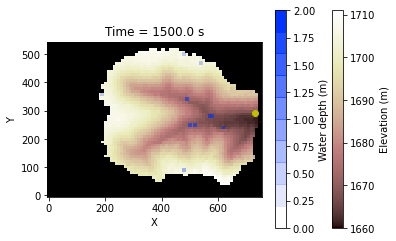

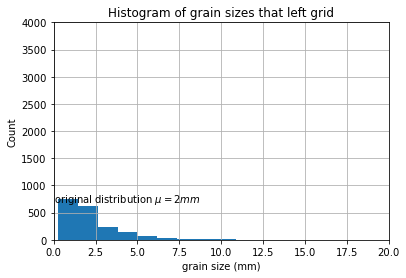

0.1
1665.0
1665.0
8.29454798819
[  2.66918501e-02   9.25908770e-03   1.05230692e-02   1.68528100e-02
   3.49887073e-02   4.08383265e-02   1.46218928e-02   2.59000062e-04
   1.22092022e-02   1.00000000e-08   6.55668688e-02   1.74611863e-03
   4.85601541e-02   3.84316596e-02   6.55668688e-02   2.77616758e-04
   2.52688058e-01   1.81234465e-01   2.33138732e-01   1.21294924e-02
   1.81234465e-01]


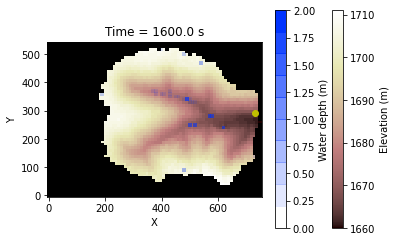

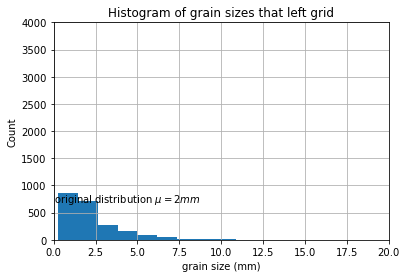

0.1
1665.0
1665.0
[  2.30629532e-02   7.73852708e-03   8.72590418e-03   1.42595677e-02
   3.00276806e-02   3.56676392e-02   1.24597099e-02   2.00172536e-04
   1.01935729e-02   1.00000000e-08   1.85057305e-01   1.11322451e-02
   3.99286902e-02   4.25739583e-02   1.85057305e-01   2.19439686e-04
   2.94892647e-01   6.58894722e-02   8.73964299e-02   9.55263209e-03
   6.58894722e-02]


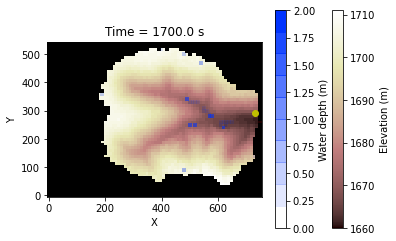

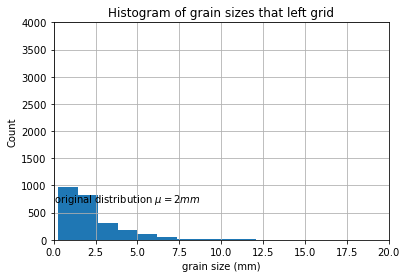

0.1
1665.0
1665.0
44.8489489623
[ 0.11025761  0.10195115  0.04795788  0.12264684  0.12118089  0.09645124
  0.07554062  0.02511018  0.04956241  0.00857195  0.16605482  0.0330135
  0.30519639  0.13819158  0.16605482  0.02126288  0.22890325  0.09093395
  0.18264031  0.05213002  0.09093395]


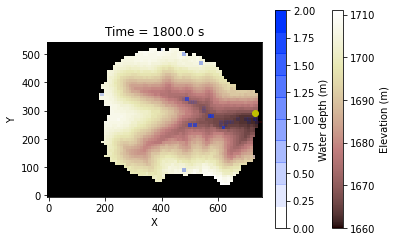

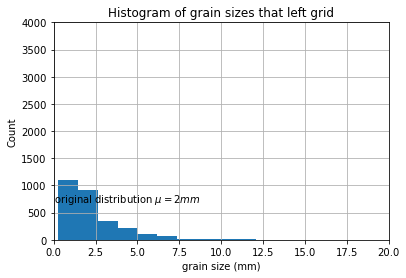

0.1
1665.0
1665.0
[  1.67650082e-01   5.24363493e-02   1.39591068e-01   9.93790740e-02
   3.07085662e-01   2.89413206e-01   9.19306982e-02   7.29578191e-03
   9.11190905e-02   3.09472913e-04   3.07980338e-01   3.55922619e-02
   6.54438131e-01   1.87737679e-01   3.07980338e-01   3.20733825e-03
   5.43039912e-01   1.76350604e-01   2.04459587e-01   1.11584821e-02
   1.76350604e-01]


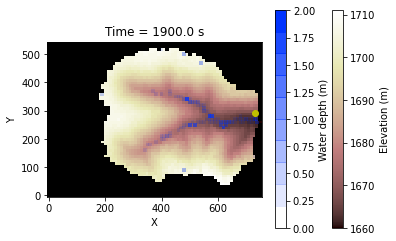

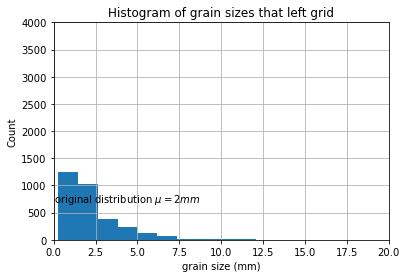

0.1
1665.0
1665.0
[  9.29499597e-02   3.00932447e-02   4.23744437e-02   5.14962037e-02
   1.22301897e-01   1.43985081e-01   4.33043338e-02   2.85759843e-03
   6.30875590e-02   1.57603408e-04   2.64486900e-01   3.03879946e-02
   7.16422085e-01   2.16073234e-01   2.64486900e-01   1.61924970e-03
   2.94420784e-01   7.46307530e-02   1.04593235e-01   9.75433972e-03
   7.46307530e-02]


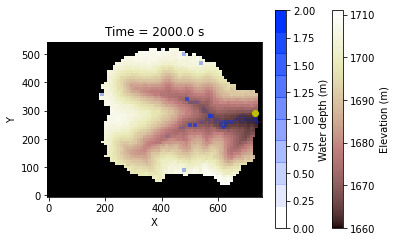

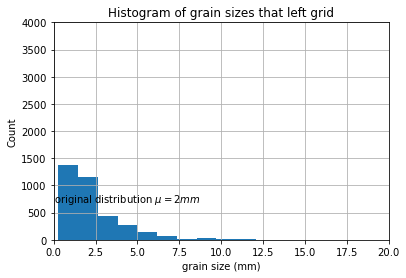

0.1
1665.0
1665.0
2.61289447695
[  9.50973615e-02   2.06457900e-02   4.33291377e-02   3.43032529e-02
   1.11065221e-01   1.14936678e-01   2.86440976e-02   2.10845123e-03
   3.55578446e-02   2.03782939e-05   1.55550181e-01   9.59615735e-03
   4.97423871e-01   1.40477040e-01   1.55550181e-01   9.19309377e-04
   1.68239725e-01   6.24505633e-02   1.00881873e-01   9.56020543e-03
   6.24505633e-02]


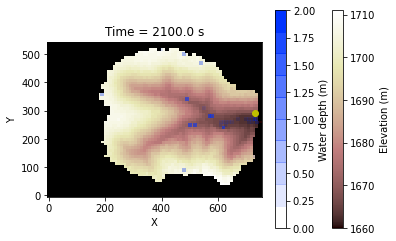

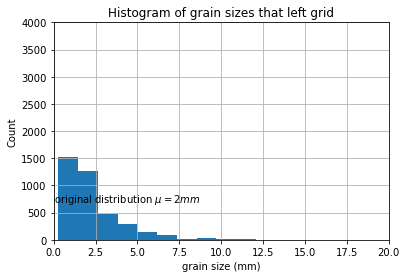

0.1
1665.0
1665.0
[  6.69431587e-02   1.52102538e-02   2.82463314e-02   2.62664201e-02
   7.99388469e-02   8.89494149e-02   2.20705562e-02   1.25433629e-03
   2.76788570e-02   1.00000000e-08   1.22308497e-01   5.28404482e-03
   1.95160798e-01   8.27204980e-02   1.22308497e-01   5.60597406e-04
   1.39949792e-01   4.84338932e-02   7.01769812e-02   7.24060026e-03
   4.84338932e-02]


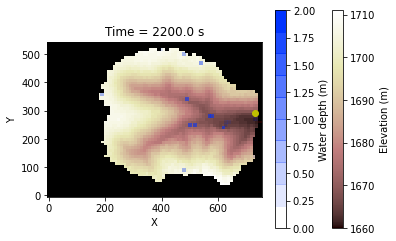

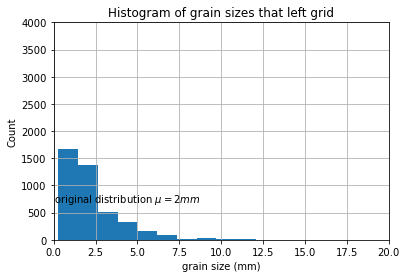

0.1
1665.0
1665.0
131.934927475
[ 0.38697911  0.28598319  0.21276098  0.32530887  0.32994396  0.27631265
  0.23739473  0.06612125  0.18039978  0.02874621  0.27413096  0.075546
  0.40856733  0.23731548  0.27413096  0.06426897  0.37936603  0.19046687
  0.36159795  0.12624025  0.19046687]


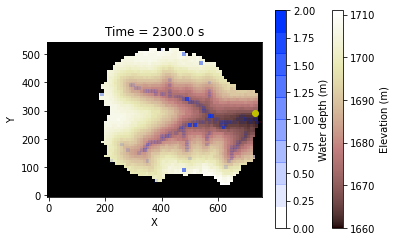

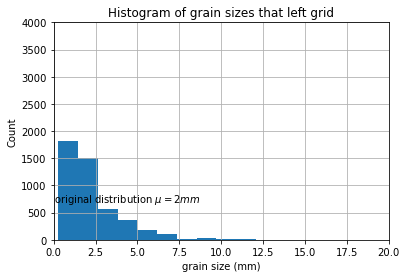

0.1
1665.0
1665.0
[ 0.29772226  0.07358471  0.37235332  0.13844326  0.92061207  0.71134485
  0.14357414  0.01765521  0.41466842  0.03415241  0.8344339   0.36335826
  1.85370433  0.54416746  0.8344339   0.00623087  1.18949643  0.39352093
  0.40084756  0.01805803  0.39352093]


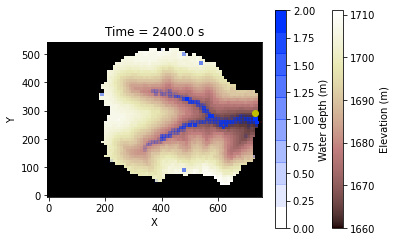

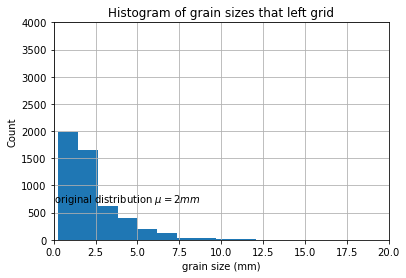

0.1
1665.0
1665.0
[  1.44126768e-01   4.29950179e-02   7.35573444e-02   6.96996582e-02
   1.87171032e-01   2.30483838e-01   5.53771435e-02   1.42613913e-03
   1.33776842e-01   7.69645658e-03   5.92207217e-01   3.18141074e-01
   2.13356388e+00   6.25846339e-01   5.92207217e-01   2.51692804e-03
   5.36731989e-01   1.03692373e-01   1.38909457e-01   1.61460830e-02
   1.03692373e-01]


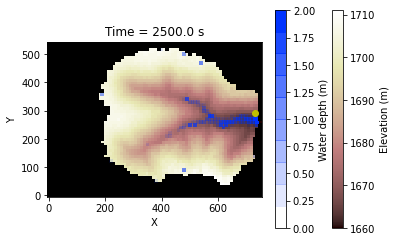

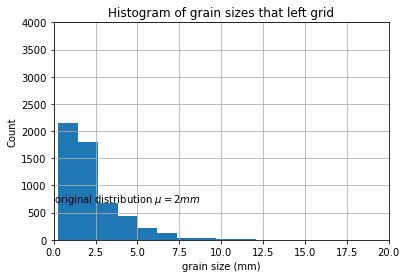

0.1
1665.0
1665.0
0.00107718022189
[  9.57022433e-02   2.98103789e-02   4.36274026e-02   5.25370172e-02
   1.19207345e-01   1.31425768e-01   4.14341095e-02   2.72974424e-03
   4.59972186e-02   3.79371396e-04   2.22574913e-01   2.42063337e-02
   1.53498482e+00   2.47570567e-01   2.22574913e-01   1.98202352e-03
   2.31796224e-01   7.52509722e-02   1.01387456e-01   1.11607295e-02
   7.52509722e-02]


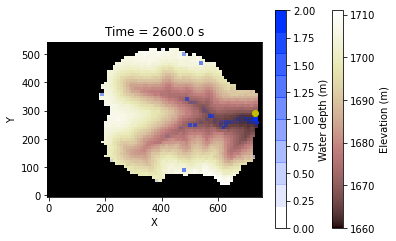

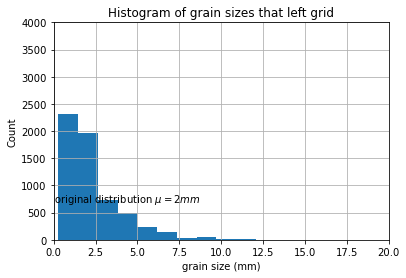

0.1
1665.0
1665.0
[  6.01895251e-02   2.00182327e-02   2.60080001e-02   3.37044347e-02
   7.69238094e-02   8.83821138e-02   2.88394485e-02   1.02948553e-03
   2.94484510e-02   1.79719531e-04   1.45262768e-01   7.67654342e-03
   3.64583733e-01   1.08898611e-01   1.45262768e-01   8.12535923e-04
   1.61256448e-01   4.94674424e-02   6.95225496e-02   6.47276578e-03
   4.94674424e-02]


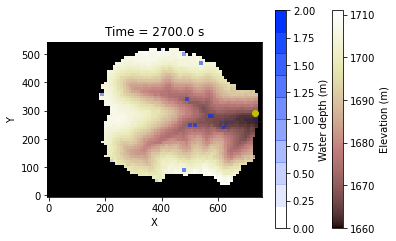

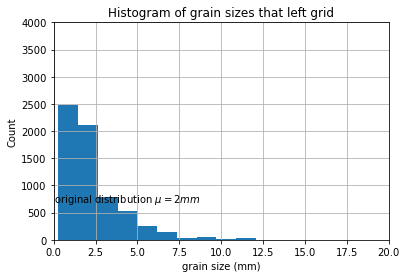

0.1
1665.0
1665.0
0.00224512490856
[  4.34143368e-02   1.43179712e-02   2.04739398e-02   2.52295751e-02
   5.57766470e-02   6.29437879e-02   2.16097241e-02   5.48766335e-04
   2.31606952e-02   8.42554388e-05   1.04126724e-01   4.30454727e-03
   1.74437251e-01   7.57145755e-02   1.04126724e-01   5.04153140e-04
   1.12453908e-01   3.68668626e-02   5.36374299e-02   4.22842646e-03
   3.68668626e-02]


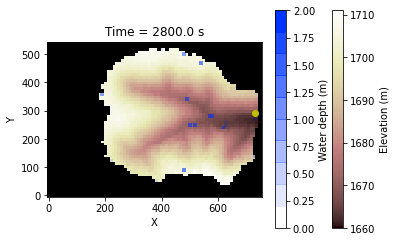

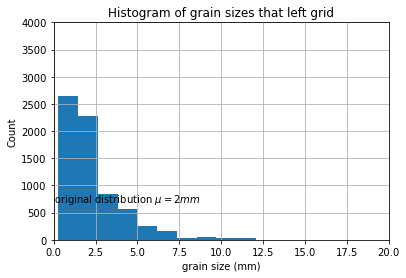

0.1
1665.0
1665.0
[  3.34909414e-02   1.09154647e-02   1.45979133e-02   1.96547490e-02
   4.40125130e-02   5.17246249e-02   1.71088322e-02   3.50614382e-04
   1.62731806e-02   4.68490965e-05   7.99422555e-02   2.68919895e-03
   9.86316243e-02   5.24727193e-02   7.99422555e-02   3.48813764e-04
   8.77943260e-02   2.94798298e-02   4.26966537e-02   3.00156444e-03
   2.94798298e-02]


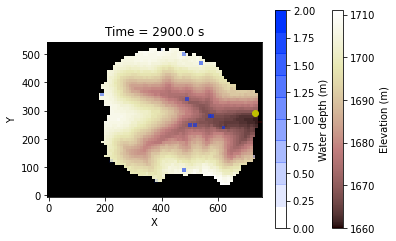

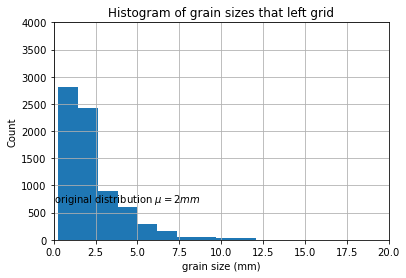

0.1
1665.0
1665.0
[  2.70706330e-02   8.71349136e-03   1.10168621e-02   1.59046090e-02
   3.57563491e-02   4.23970349e-02   1.39539003e-02   2.48841830e-04
   1.31342329e-02   2.97042455e-05   6.56515140e-02   1.78728889e-03
   6.08436384e-02   4.04161288e-02   6.56515140e-02   2.59399244e-04
   7.59104717e-02   2.42648732e-02   3.51293118e-02   2.25642966e-03
   2.42648732e-02]


In [ ]:
# driving the model forward in a loop
elapsed_time = 1.
run_time = 5000
iters = 0

# #Figure outputs
# mydpi = 96
# sizeFigure = 400
# system("rm -r ResultImages/*.png")

rainfall_id = 0

dt_sed = 100

run_time_slices = np.arange(500,run_time+1,dt_sed)

for t in run_time_slices:
    
    elapsed_time_FP = float(elapsed_time)
    
    while elapsed_time < t:
    
        # make rain

        if int(elapsed_time) in scaled_days_storms:
            # print("STORMMMM")
            # Update rainfall dataset id
            rainfall_id += 1
            rainfall_name = 'rainfall__flux_' + str(rainfall_id)
            # print(rainfall_id)

            # Avoid last time step
            if rainfall_id <= len(scaled_days_storms):
                # Read rainfall data
                # rmg.at_node.pop('rainfall__flux')
                read_esri_ascii('./rainfall_series/rainfall_' + str(rainfall_id) + '.asc', 
                                grid=rmg, name=rainfall_name)
                # Add rainfall event to water depth
                rmg.at_node['surface_water__depth'] += rmg.at_node[rainfall_name]
                print(np.sum(rmg.at_node[rainfall_name]))
    
        # route overland flow

        # First, we calculate our time step.
        dt_overland = 1 #networkOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        networkOF.overland_flow()
        # Increased elapsed time
        elapsed_time += dt_overland
        #print("Model time: ",elapsed_time/(60*60*24), "days passed")
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q_output = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q_output[outlet_link_to_sample]) * rmg.dx)
        h_output = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.abs(h_output[outlet_nearest_raster_cell]))
#         print(elapsed_time)

    # route sediment

    # updated the water depth in network graph
    for i in range(new_grid.number_of_links):
        idx_node_1_link = new_grid.nodes_at_link[i][0]
        idx_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[idx_node_1_link], new_grid.y_of_node[idx_node_1_link]])
        nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_nearest_raster_cell ] 
    new_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
    print(new_grid.at_link["flow_depth"])
    
    nst.run_one_step(dt_sed)
    
        #Plot overland flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()

    #grain size
    parcel_D = parcels.dataset.D.values.copy()
    parcel_D_off_grid=parcel_D[parcels.dataset["element_id"].values==-2] 

    # the histogram of the data
    plt.hist(parcel_D_off_grid*1000, histtype='bar')
    plt.xlabel('grain size (mm)')
    plt.ylabel('Count')
    plt.title('Histogram of grain sizes that left grid')
    plt.text(0.011, 700, r'original distribution $\mu=2 mm$')
    plt.xlim(0, 20)
    plt.ylim(0, 4000)
    plt.grid(True)
    plt.show()
    
    print(np.abs(h[outlet_nearest_raster_cell]))
    print(new_grid.at_node['bedrock__elevation'][14] )
    print(new_grid.at_node['topographic__elevation'][14] )
    # change floodplain
    
    #Plot sediment parcels locations
 #   fig = plot_network_and_parcels(
 #           new_grid, parcels, 
 #           parcel_time_index=len(parcels.time_coordinates)-1)
#    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
#    plt.title(f'Time = {round(elapsed_time,1)} s')
#    plt.show()
    
#     # route floodwater on floodplain
    
#     # First, we calculate our time step.
#     dt = of.calc_time_step()
#     # Now, we can generate overland flow.
#     of.overland_flow()
#     SI.run_one_step(dt)
    
#     if iters %50==0:
#         print('Elapsed time: ', elapsed_time)
#         fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
#         plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
#         imshow_grid(grid,'surface_water__depth',
#         limits=(0,1),cmap=WaterMap,                    
#         colorbar_label="Water depth (m)",                    
#         plot_name="Time = %i" %elapsed_time)
#         fig.savefig("ResultImages/" + str(iters).zfill(5) + ".png")
    
#     elapsed_time += dt
#     iters += 1



In [ ]:
print(new_grid.at_node.keys())
print(new_grid.at_node['topographic__elevation'])

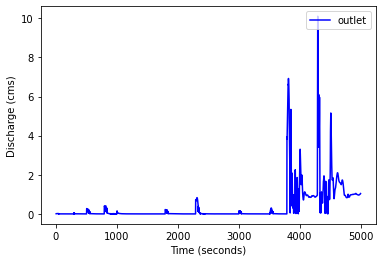

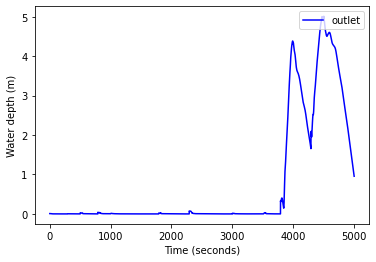

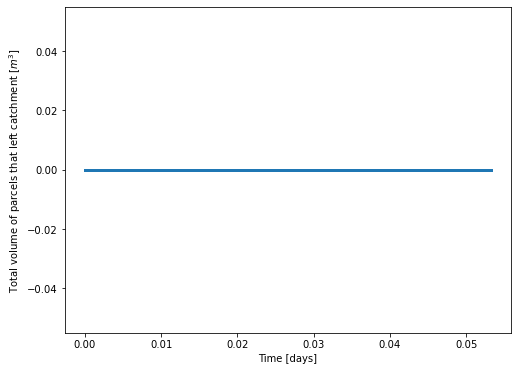

In [57]:

# Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(f"runoff_discharge.jpeg")

fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig("runoff_waterdepth.jpeg")


## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)

plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,
         '-',
         linewidth=3, 
        )
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 


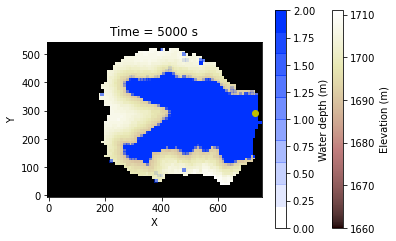

In [20]:
# land flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
#     fig.savefig(

In [35]:
new_grid

<xarray.Dataset>
Dimensions:        (Two: 2, link: 21, node: 22)
Coordinates:
  * node           (node) int32 0 1 2 3 4 5 6 7 8 ... 13 14 15 16 17 18 19 20 21
Dimensions without coordinates: Two, link
Data variables:
    mesh           <U1 'a'
    y_of_node      (node) float64 168.6 171.1 185.8 194.8 ... 371.9 396.4 413.6
    x_of_node      (node) float64 344.0 661.4 356.6 679.2 ... 372.3 297.4 432.8
    nodes_at_link  (link, Two) int32 0 2 1 3 2 4 3 5 ... 18 17 19 18 20 19 18 21

In [38]:
parcels.time_coordinates

[0.0]

ValueError: trying to plot on an inactive link. this should not happen.

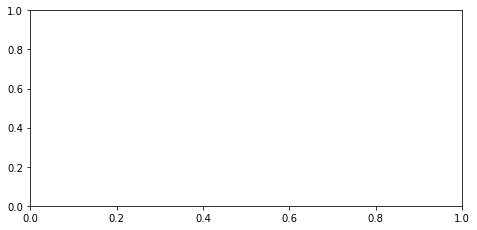

In [34]:
fig = plot_network_and_parcels(
    new_grid, parcels, 
    parcel_time_index=0)
plt.title(f'Time = {round(elapsed_time,1)} s')
plt.show()
    

In [ ]:
# # plotting model results

# images=[]
# original_files=list(glob("./ResultImages/*.png"))
# original_files.sort(reverse=False)
# for file_ in original_files:
#     images.append(imageio.imread(file_))
# imageio.mimsave('./animation.gif', images, duration=1/5, subrectangles=True)



In [ ]:

# # Check the 2D domain topography
# fig = plt.figure(figsize=(10,8))

# ## Cross Section
# ax1 = plt.subplot(2,1,1)
# ax1.plot(grid.node_x[grid.node_y==nX/2],z[grid.node_y==nX/2],label="Cross Section")
# ax1.set_ylabel("Elevation (??)")
# ax1.set_xlabel("Distance X (??)")
# ax1.legend()

# ## Long Section
# ax2 = plt.subplot(2,1,2)
# ax2.plot(grid.node_y[grid.node_x==nY/2],z[grid.node_x==nY/2],label="Longitudinal Section")
# ax2.set_ylabel("Elevation (??)")
# ax2.set_xlabel("Distance Y (??)")
# ax2.legend()

# fig.show()